<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

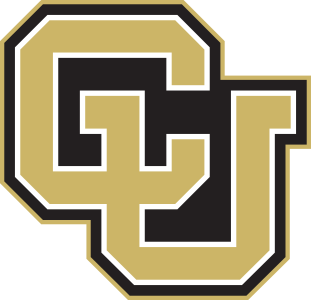

# Lecture 03, hands-on: $K$-Means
*(CPBS 7602: Introduction to Big Data in the Biomedical Sciences)*

By __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Goals
* Identify the components of an unsupervised learning problem.
* Use sklearn for clustering analysis and familiarize yourself with the API.
* Basic understanding of centroid-based algorithms ($k$-means) and other algorithms.
* Clustering in practice: feature scaling and interpretability.

# Reading Material

Check out different resources and documentation from sklearn.

* [Clustering guide](https://scikit-learn.org/1.5/modules/clustering.html) from sklearn:
  * Introduction to **different clustering methods**.
  * Clustering **performance evaluation**:
    * **When we know** the ground-truth (external metrics):
      * Based on Rand Index, such as ARI.
      * Based on mutual information, such as NMI.
    * **When we don't know** the ground-truth (internal metrics):
      * Silhouette coefficient
      * Calinski-Harabasz Index
      * Davies-Bouldin Index

# Modules

In [1]:
# load modules
import numpy as np
import pandas as pd
from sklearn import cluster
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_rand_score as ari
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from seaborn import pairplot

np.random.seed(0)

# Dataset 1

Load dataset. Feature names have the format `f[NUMBER]`. The column "labels", if present, contains the true labels/clusters.

In [38]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/8elyky9mtq9nser82xk05/dataset01.tsv?rlkey=wlue2ejkkyen8ghdxah6yqso2&st=n9x9muq9&dl=1",
    sep="\t",
)

## Question 1

How many objects ($n$) and features ($d$) are in this dataset?

In [3]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      100 non-null    float64
 1   f2      100 non-null    float64
 2   f3      100 non-null    float64
 3   f4      100 non-null    float64
 4   f5      100 non-null    float64
 5   f6      100 non-null    float64
 6   f7      100 non-null    float64
 7   f8      100 non-null    float64
 8   f9      100 non-null    float64
 9   f10     100 non-null    float64
 10  f11     100 non-null    float64
 11  f12     100 non-null    float64
 12  labels  100 non-null    int64  
dtypes: float64(12), int64(1)
memory usage: 10.3 KB


In [5]:
data.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,labels
0,-0.330916,-0.411204,1.806458,3.881925,1.703582,0.184864,1.565088,1.386821,1.942868,0.640872,1.592145,3.250613,1
1,0.005613,-0.003614,0.177467,2.373105,1.515870,2.381005,2.565380,2.253157,2.118793,0.798179,0.824951,1.711693,1
2,-0.050342,-0.338685,2.532612,0.597579,2.660178,2.668388,0.638148,2.091127,2.294401,0.355153,0.134495,1.924682,1
3,0.100639,0.693432,2.062112,2.031477,2.613821,3.768640,2.383001,1.690449,1.502907,1.180356,0.706819,0.027658,1
4,-0.160311,-0.576029,2.931509,1.552599,3.799989,1.763680,2.892516,0.358567,2.479182,1.460836,3.351244,0.317846,1


_Answer_: 12 features, 100 objects

## Question 2

Does this dataset have the ground truth (or "true") labels/clusters?
How many clusters are present in this ground truth, and how many objects are in each "true" cluster?
If we ran a clustering algorithm on the data, which metrics can we use to measure performance given the data?

In [6]:
print(data["labels"].unique())

[1 2 3 4]


In [7]:
len(data[data["labels"] == 1])

25

In [8]:
len(data[data["labels"] == 2])

25

In [9]:
len(data[data["labels"] == 3])

25

In [10]:
len(data[data["labels"] == 4])

25

_Answer_: Yes, labels. There are 4 labels. 25 objects each per cluster. We can use Mean Squared Error for instance to measure performance since we have a ground truth.

## Question 3

We want to understand whether there is some structure among the objects in the data.
Perform a cluster analysis using $K$-Means to answer the following questions:
1. Are there stable clusters in the data?
2. What are the optimal parameters of a $K$-Means model that maximize the agreement with the true labels? Use at least two different metrics to compare the true labels with the $K$-Means labels.
3. Do clustering solutions in 1. and 2. coincide? Why or why not?

In [11]:
# input
X = data.drop(columns=["labels"])
# target
y = data["labels"]
model = cluster.KMeans(n_clusters=4, n_init="auto")
model.fit(X)
y_pred = model.predict(X)

# create clusters × features matrix:
centroids_k4 = model.cluster_centers_

K-Means Objective: 1443.12


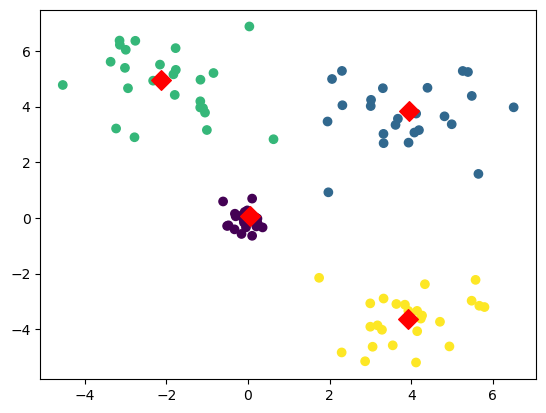

In [12]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y)
plt.scatter(
    model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker="D", c="r", s=100
)
print("K-Means Objective: %.2f" % -model.score(X))

In [13]:
#implement consensus index method

# we pick a range that is reasonable for our data:
# usually between 2 and sqrt(n)
Ks = range(2, 11)
n_reps = 10
cluster_labels = []
pairwise_ari = []
centroid_positions = {}
stability_scores = []

for k in Ks:
    labels = []
    centroids = []

    for _ in range(n_reps):
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))
        centroids.append(model.cluster_centers_)

    cluster_labels.append(labels)
    centroid_positions[k] = centroids

    # Compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)
    pairwise_ari.append(ari_distances)
    stability_scores.append(ari_distances.mean())

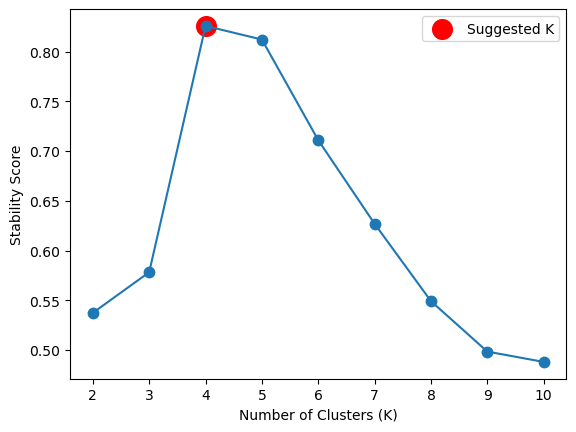

In [14]:
#visualize
plt.plot(Ks, stability_scores, marker=".", linestyle="-", markersize=15)
plt.scatter(
    4,
    stability_scores[2],
    s=200,
    color="red",
    label="Suggested K",
)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")
plt.legend()
plt.show()

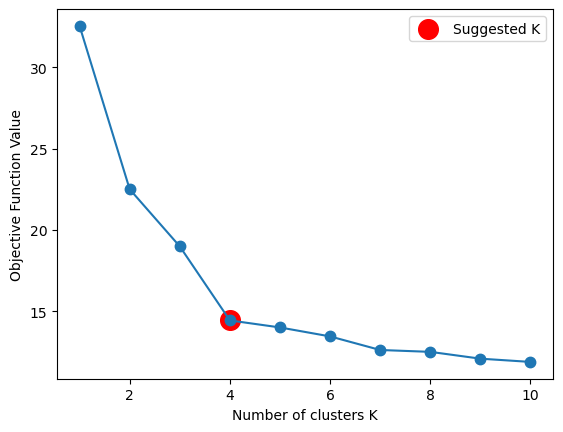

In [15]:
# implement elbow method
Ks, objs = range(1, 11), []
for k in Ks:
    model = cluster.KMeans(n_clusters=k, n_init="auto")
    model.fit(X)
    objs.append(-model.score(X) / X.shape[0])

plt.plot(Ks, objs, ".-", markersize=15)
plt.scatter([4], [objs[3]], s=200, color="red", label="Suggested K")
plt.xlabel("Number of clusters K")
plt.ylabel("Objective Function Value")
plt.legend()

_Answer_: both consensus index and elbow methods agree on a K=4. Yes, there are stable clusters in the data.

## Question 4

Use at least two internal metrics to measure the quality of the clustering solutions.

1. Do they match with the true labels? Why?
2. Do they match among themselves?

In [16]:
# Comparison of k means cluster assignment with true labels
# Adjusted Rand Index (ARI) - we already computed this for stability when
# looking at consensus index. Will not look at it for external validity.

ari_vs_truth = ari(y, y_pred)
print(ari_vs_truth)


0.9455962431932857


In [17]:
# Normalized Mutual Information (NMI)
metrics.adjusted_mutual_info_score(y, y_pred)  

np.float64(0.9368239333004521)

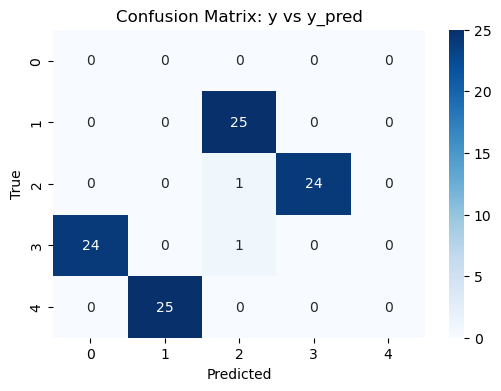

In [18]:
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: y vs y_pred")
plt.show()

_Answer_: yes, both ARI and NMI say that k=4 k-means clustering yields a high accuracy clustering

## Question 5

Explore the different features of the dataset and find the top ones that are most helpful to capture the true labels in the data. Answer the following questions:

1. Create 2D scatterplots of the data using all possible combinations of feature pairs. _Tip:_ Look at the [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function in `seaborn`.
1. What are the most important features that the algorithm used to accurately cluster the data? Are some features more important than others?
1. Create a 2-dimensional plot using the two top features you found. Include the true labels and centroids learned by $K$-Means using the $K$ with the most accurate solution. _Tip:_ the [`scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) function from seaborn returns a matplotlib's Axes object that you can use to draw on top of the original plot.
1. Related to the second question: think about some approaches that could be used to automatically learn the most important features that are driving clustering results.

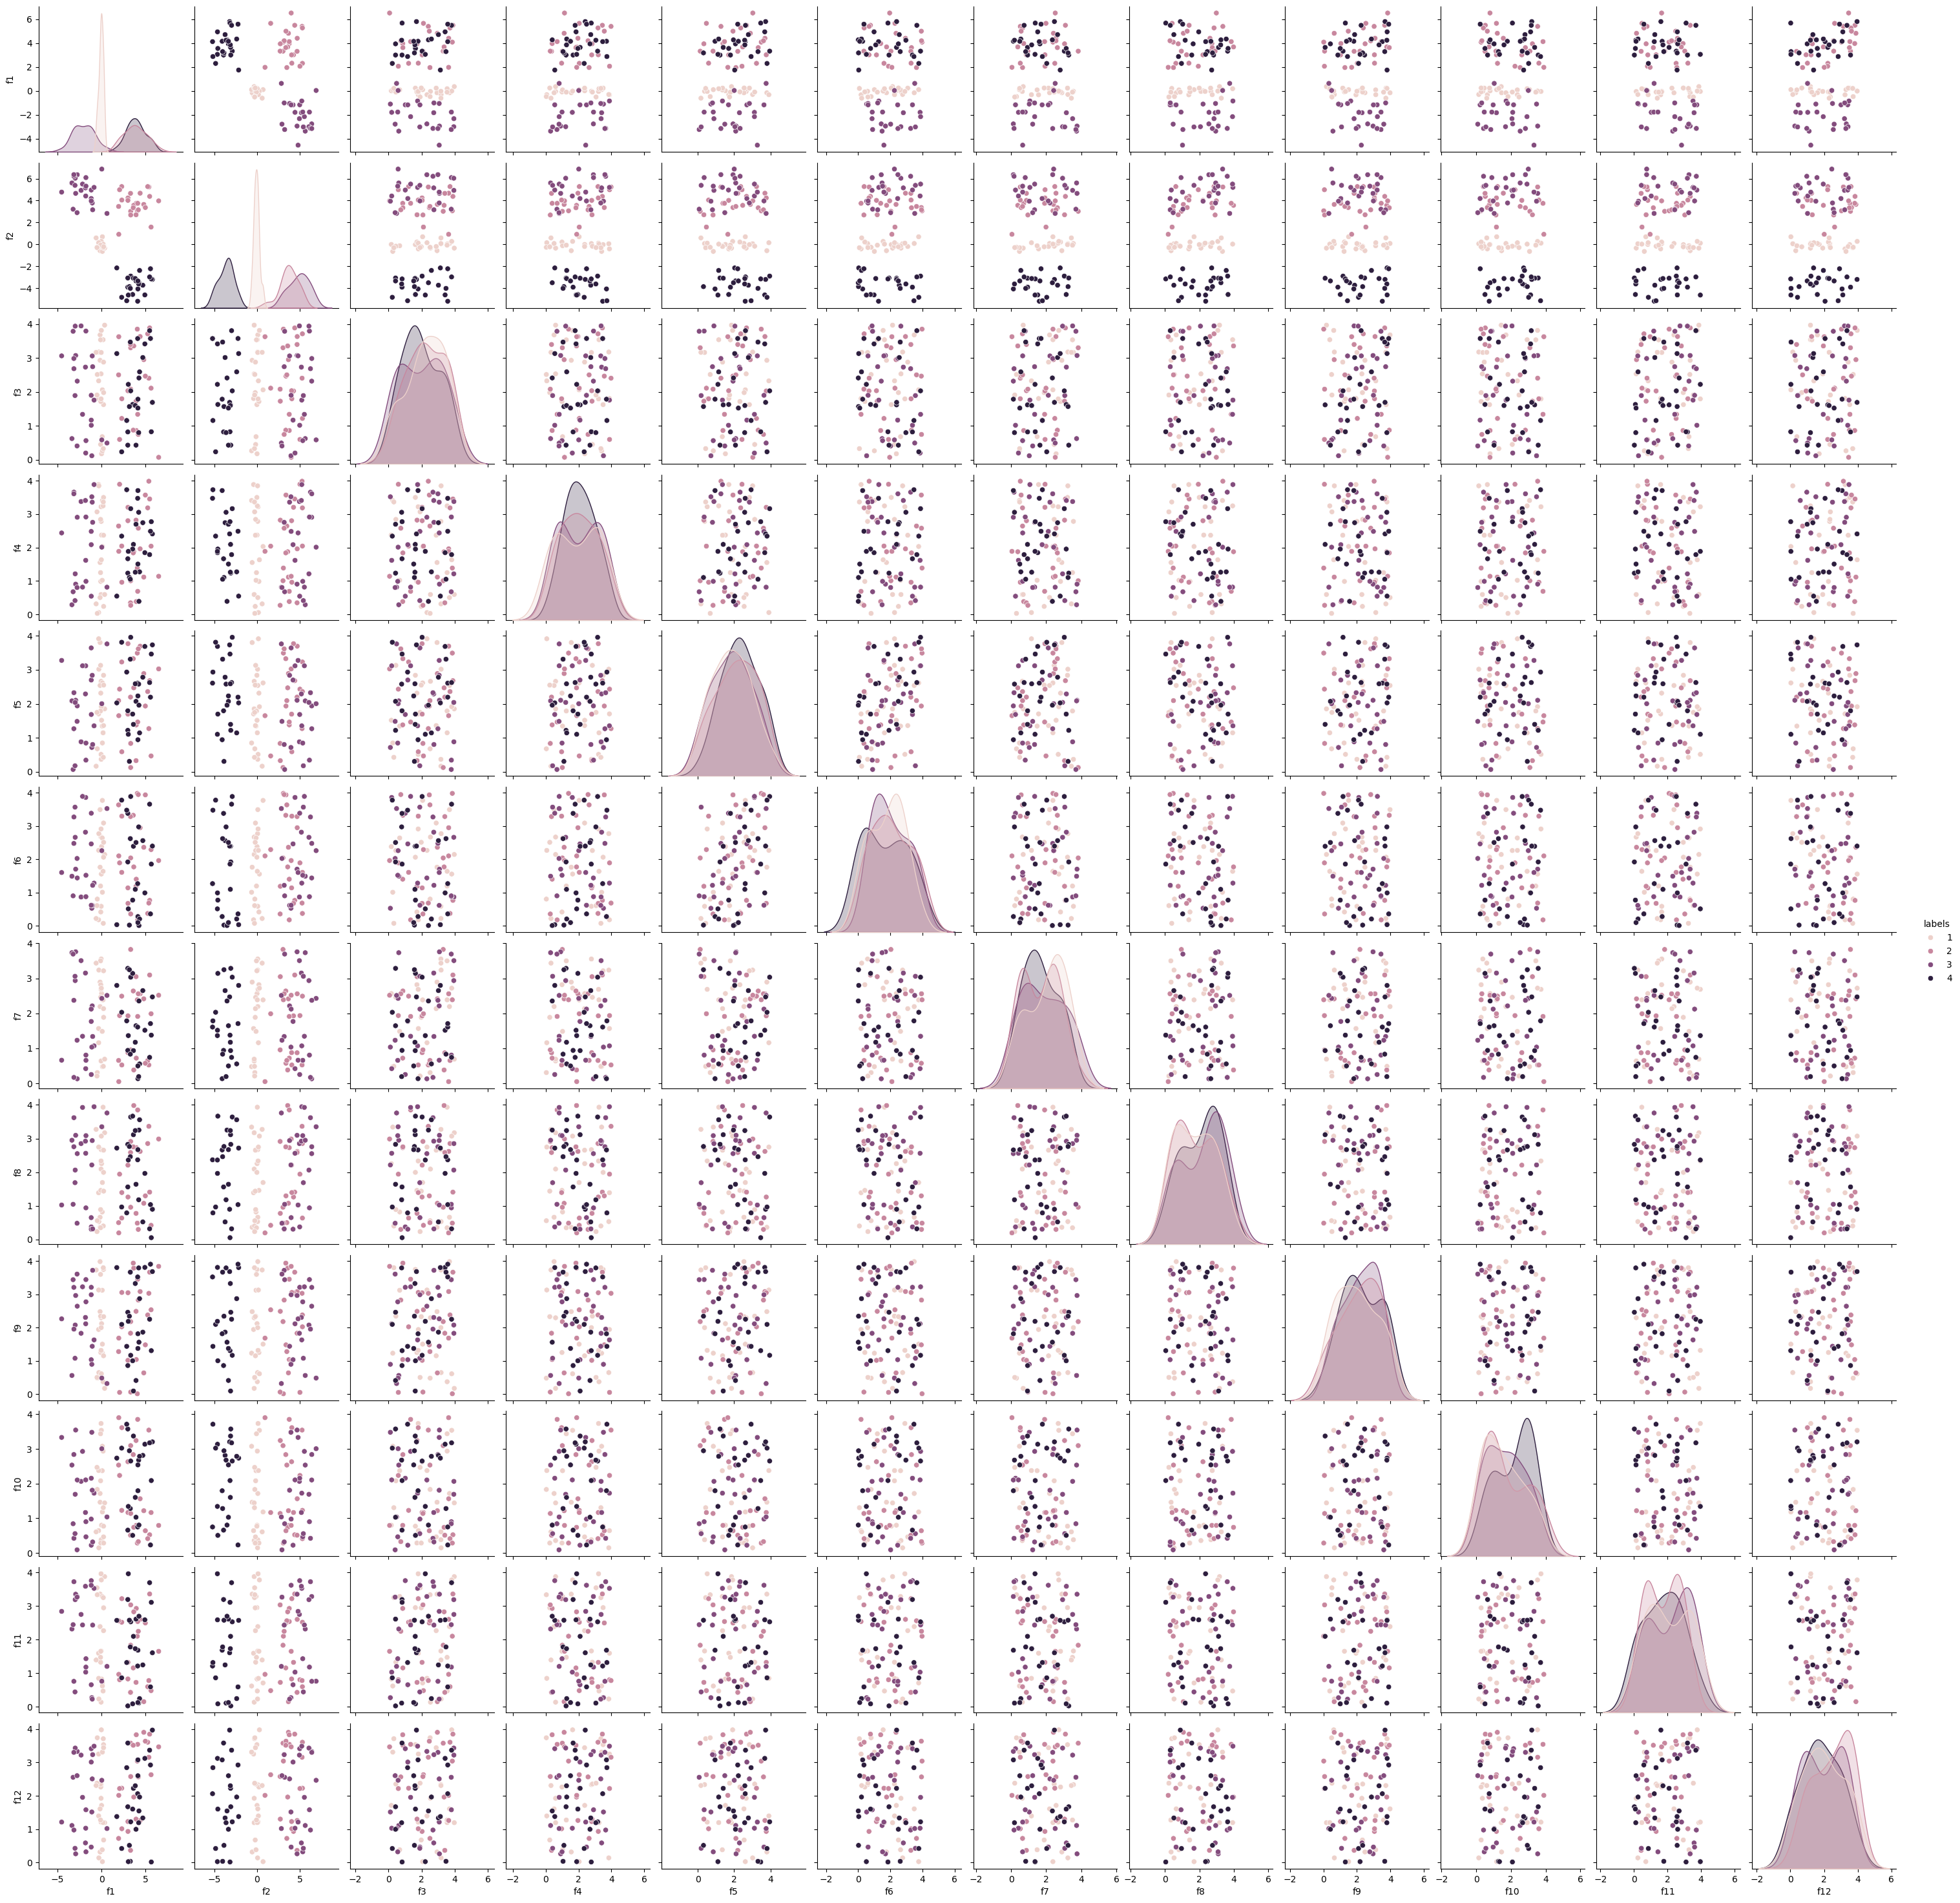

In [19]:
sns.pairplot(data, hue = "labels")

In [39]:
#re-training and defining the model just in case

model = cluster.KMeans(n_clusters=4, n_init="auto")
model.fit(X)
y_pred = model.predict(X)

# create clusters × features matrix:
centroids_k4 = model.cluster_centers_

In [40]:
# to look at most important features, can find which features vary the
# most between the 4 centroid coordinates.

# std dev across centroids, perfeature
feature_importance = centroids_k4.std(axis=0)

for f, score in zip(X.columns, feature_importance):
    print(f"{f}: {score:.4f}")

f1: 2.6038
f2: 3.3733
f3: 0.1032
f4: 0.0803
f5: 0.2018
f6: 0.1203
f7: 0.1137
f8: 0.1478
f9: 0.1458
f10: 0.2162
f11: 0.1805
f12: 0.2554


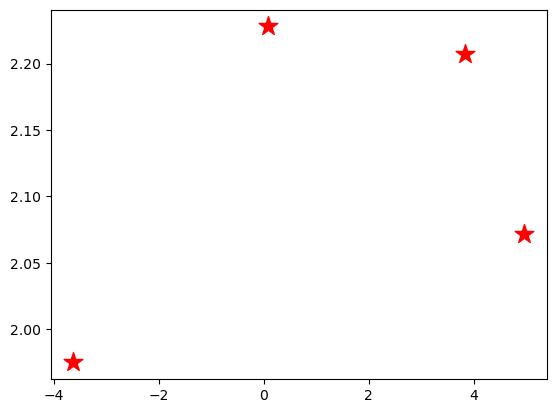

In [41]:
plt.scatter(centroids_k4[:, 1], centroids_k4[:, 2], marker="*", s=200, c="red")

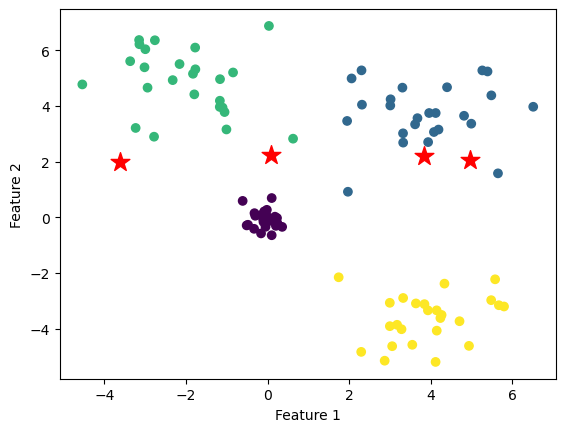

In [42]:
plt.scatter(data["f1"], data["f2"], c=data["labels"])
plt.scatter(centroids_k4[:, 1], centroids_k4[:, 2], marker="*", s=200, c="red")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

_Answer_: f1 and f2 are most important

## Question 6

Let's assume that our dataset's objects are people and its features include measurements such as height (in meters, with values such as `1.55` or `1.95`) and year of birth (such as `1945` or `2001`). Clearly, these two features have different scales. Let's simulate that in our dataset:

In [24]:
# let's see what are the stats across features in the original data
data.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,labels
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.426425,1.222585,2.122137,2.034657,2.047784,1.901838,1.814660,1.972853,2.160616,1.802824,1.945195,2.067451,2.500000
std,2.762913,3.476864,1.169307,1.143062,1.063029,1.185629,1.080893,1.161838,1.157607,1.147469,1.174753,1.174859,1.123666
min,-4.539012,-5.190981,0.073070,0.033522,0.070147,0.012054,0.048035,0.049635,0.014697,0.088058,0.023665,0.017672,1.000000
25%,-0.487561,-1.019238,1.166957,1.018976,1.270292,0.853160,0.789670,0.892831,1.247181,0.764301,0.825872,1.193729,1.750000
50%,1.183115,0.806465,2.049049,2.021329,2.055746,1.907358,1.897732,2.149544,2.183210,1.701763,1.962398,2.139220,2.500000
75%,3.929524,4.200504,3.139445,3.056537,2.837758,2.781726,2.641203,2.915272,3.147419,2.835454,2.944727,3.221551,3.250000
max,6.508632,6.873952,3.968635,3.980859,3.954391,3.979962,3.825164,3.981973,3.979669,3.899856,3.958024,3.975148,4.000000


In [25]:
data_scaled = data.copy()

In [26]:
from sklearn.preprocessing import minmax_scale

In [27]:
# f6 will be height
data_scaled["f6"] = minmax_scale(data["f6"], feature_range=(1.2, 2.05))

# and f7 will be year of birth
data_scaled["f7"] = np.ceil(minmax_scale(data["f7"], feature_range=(1945, 2001)))

In [28]:
# let's verify the stats/ranges of our new features
data_scaled.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,labels
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.426425,1.222585,2.122137,2.034657,2.047784,1.604827,1971.710000,1.972853,2.160616,1.802824,1.945195,2.067451,2.500000
std,2.762913,3.476864,1.169307,1.143062,1.063029,0.253984,16.010284,1.161838,1.157607,1.147469,1.174753,1.174859,1.123666
min,-4.539012,-5.190981,0.073070,0.033522,0.070147,1.200000,1945.000000,0.049635,0.014697,0.088058,0.023665,0.017672,1.000000
25%,-0.487561,-1.019238,1.166957,1.018976,1.270292,1.380180,1956.750000,0.892831,1.247181,0.764301,0.825872,1.193729,1.750000
50%,1.183115,0.806465,2.049049,2.021329,2.055746,1.606009,1973.000000,2.149544,2.183210,1.701763,1.962398,2.139220,2.500000
75%,3.929524,4.200504,3.139445,3.056537,2.837758,1.793315,1984.000000,2.915272,3.147419,2.835454,2.944727,3.221551,3.250000
max,6.508632,6.873952,3.968635,3.980859,3.954391,2.050000,2001.000000,3.981973,3.979669,3.899856,3.958024,3.975148,4.000000


It can be seen that the mean, standard deviation, minimum, and maximum values are very different now when we compare the features.

1. How does our clustering approach perform in this new dataset?
2. Why is this happening? How can we fix it? *Tip:* take a look at the [preprocessing functions in sklearn](https://scikit-learn.org/1.5/modules/preprocessing.html). Try the [StandardScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

_Answer_: add answer

# Dataset 2

In [29]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/mfllucl6fu2awou5hg90p/dataset02.tsv?rlkey=vcbr61pr5159qo4ynh49vpq4o&st=gec1pm6r&dl=1",
    sep="\t",
)

## Previous Questions 1-5

Answer the same questions as for Dataset 1.

### Question 1

_Answer_: add answer

### Question 2

_Answer_: add answer

### Question 3

_Answer_: add answer

### Question 4

_Answer_: add answer

### Question 5

_Answer_: add answer

# Dataset 3

In [30]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/2wtandc0jofhw0i4ivh1v/dataset03.tsv?rlkey=jtv6zbpaw0c5v70kd73uj2ccs&st=mkv2zlzs&dl=1",
    sep="\t",
)

## Previous Questions 1-5

Answer the same questions as for Dataset 2.

**In addition**, answer Question 7 below for this dataset.

### Question 1

_Answer_: add answer

### Question 2

_Answer_: add answer

### Question 3

_Answer_: add answer

### Question 4

_Answer_: add answer

### Question 5

_Answer_: add answer

## Question 7

As you probably guessed after answering Question 5 (Dataset 3) and making the plot, this dataset has an unusual structure: it has two concentric circles (or rings).
It was generated using the function [`make_circles`](https://scikit-learn.org/dev/modules/generated/sklearn.datasets.make_circles.html) from sklearn.
These complex datasets are used to test different clustering and classification algorithms with different degrees of difficulty.

So here you have the **first question**:
1. $K$-Means cannot capture this structure. Why not?

Now, let's try to answer Questions 3-5 but using different clustering algorithms and explore different parameters.
Some suggestions are:
* [Spectral Clustering](https://scikit-learn.org/1.5/modules/clustering.html#spectral-clustering):
  * It computes a low-dimensional embedding of the input data where the complex data structures (such as the rings) are more apparent. Then it applies $K$-Means on this embedding.
  * A suggestion on how to run it:

    ```python
        cluster.SpectralClustering(
            n_clusters=k, affinity="nearest_neighbors", n_init=1
        )
    ```

    You can try different parameters such as `affinity` or `gamma`.
* [DBSCAN](https://scikit-learn.org/1.5/modules/clustering.html#dbscan):
  * This algorithm is very different from $K$-Means. It is not centroid-based, but density-based. Some analyses, such as Consensus Index, are not directly applicable here.
  * The most important parameter is `eps`: make sure you use values around `0.30` for this dataset. One way to generate values in an interval is to use `np.linspace(0.20, 0.50, 100)`
  * A suggestion on how to run it:

    ```python
        model = cluster.DBSCAN(eps=eps_val)
    ```

* [Hierarchical clustering](https://scikit-learn.org/1.5/modules/clustering.html#hierarchical-clustering):
  * This is a classic algorithm, very popular.
  * In addition to returning a single, flat partition, hierarchical clustering can produce a hierarchy of partitions, where clusters are subsequently divided into smaller ones. This hierarchical structure might be very useful in particular problems where we expect this data structure.
  * The main parameter, in addition to the number of clusters, is the `linkage` criteria that determines how to merge clusters.

Then also answer these **other questions**:

2. Were you successful with a different clustering algorithm? Which one?
3. Why did the new algorithm work?

_Answer_: add answer

### Spectral Clustering

#### Question 3

#### Question 4

#### Question 5

### DBSCAN

#### Question 3

#### Question 4

#### Question 5

### Hierarchical Clustering

#### Question 3

#### Question 4

#### Question 5